In [1]:
# Importing the required libraries:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
# Loading the Dataset:

path = "./UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [3]:
# Creating the Image, Ages and the Genders Array:

images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

In [11]:
# Defining the function to display Images:

def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

Gender: 0 Age: 15


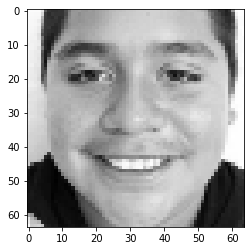

In [12]:
# Displaying an Image from the Dataset:

idx = 700
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [13]:
# Function for defining the Age Groups:

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

In [7]:
# Pre-processing:

target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]

features = features / 255

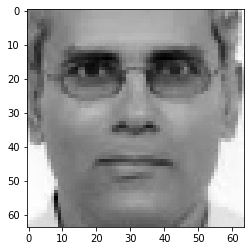

In [8]:
display(features[550])

In [9]:
# Splitting the Original Dataset into Training and Testing Dataset:

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [10]:
# Defining the Model Layers:

inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

2022-05-02 19:42:44.125987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 19:42:44.721938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [11]:
# Compiling the Model:

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [12]:
# Summary of the Model:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [13]:
# Training the Model:

h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 40, batch_size=128,shuffle = True)

Epoch 1/40


2022-05-02 19:42:48.439961: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-05-02 19:42:48.944314: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


149/149 [==============================] - 6s 20ms/step - loss: 0.9122 - dense_3_loss: 0.2167 - dense_9_loss: 0.6954 - dense_3_accuracy: 0.0109 - dense_9_accuracy: 0.5148 - val_loss: 0.7341 - val_dense_3_loss: 0.0428 - val_dense_9_loss: 0.6914 - val_dense_3_accuracy: 0.0124 - val_dense_9_accuracy: 0.5304
Epoch 2/40
149/149 [==============================] - 2s 16ms/step - loss: 0.7322 - dense_3_loss: 0.0600 - dense_9_loss: 0.6722 - dense_3_accuracy: 0.0172 - dense_9_accuracy: 0.5253 - val_loss: 0.5964 - val_dense_3_loss: 0.0298 - val_dense_9_loss: 0.5665 - val_dense_3_accuracy: 0.0245 - val_dense_9_accuracy: 0.7701
Epoch 3/40
149/149 [==============================] - 2s 15ms/step - loss: 0.6513 - dense_3_loss: 0.0482 - dense_9_loss: 0.6031 - dense_3_accuracy: 0.0217 - dense_9_accuracy: 0.6846 - val_loss: 0.5170 - val_dense_3_loss: 0.0242 - val_dense_9_loss: 0.4928 - val_dense_3_accuracy: 0.0245 - val_dense_9_accuracy: 0.8203
Epoch 4/40
149/149 [==============================] - 2s 16m

In [14]:
# Saving the Model:

model.save('data.h5')

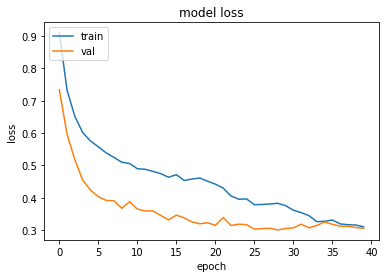

In [15]:
# Plotting the Training and the Validation Losses:

history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Defining the functions for getting the Predictions:

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)

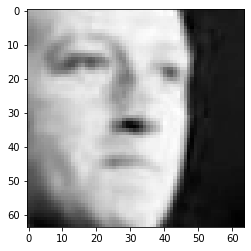

Actual Gender: Male Age: 26
Values: [array([[0.6475069]], dtype=float32), array([[0.06610057]], dtype=float32)] 
Predicted Gender: Male Predicted Age: Unknown


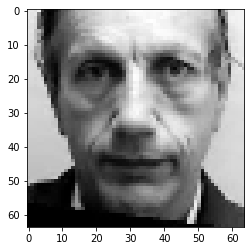

Actual Gender: Male Age: 53
Values: [array([[0.6891201]], dtype=float32), array([[5.251486e-13]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


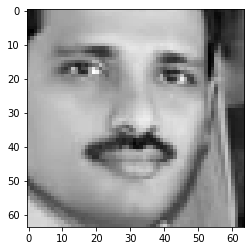

Actual Gender: Male Age: 23
Values: [array([[0.5778694]], dtype=float32), array([[1.2045262e-12]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


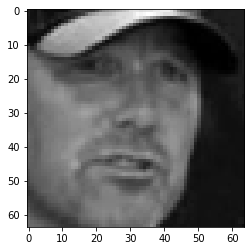

Actual Gender: Male Age: 38
Values: [array([[0.68036115]], dtype=float32), array([[0.00014179]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


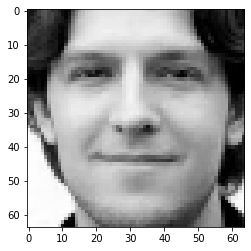

Actual Gender: Male Age: 29
Values: [array([[0.4928268]], dtype=float32), array([[0.01156809]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


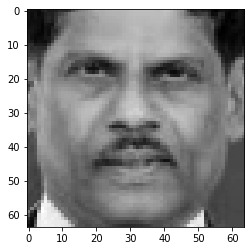

Actual Gender: Male Age: 55
Values: [array([[0.68710375]], dtype=float32), array([[8.639012e-15]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


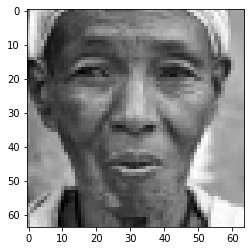

Actual Gender: Female Age: 65
Values: [array([[0.7246034]], dtype=float32), array([[0.88235474]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


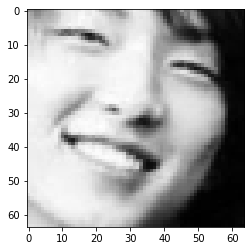

Actual Gender: Male Age: 24
Values: [array([[0.54874116]], dtype=float32), array([[0.06037114]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


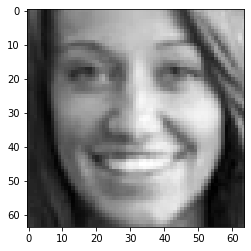

Actual Gender: Female Age: 25
Values: [array([[0.6697812]], dtype=float32), array([[0.8852902]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


In [17]:
# Taking the predictions for a set of sample data points:

indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)